In [7]:
import os
import cv2
import numpy as np
import glob
import math
# Import of Metavision Machine Learning binding
import metavision_sdk_ml
import metavision_sdk_cv
from metavision_sdk_core import EventBbox
from metavision_sdk_core import BaseFrameGenerationAlgorithm
from metavision_core.event_io.py_reader import EventDatReader
from metavision_core.event_io.events_iterator import EventsIterator
from metavision_core.event_io import EventNpyReader

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [11, 7]

[[  0   0 255]
 [  0  85 255]
 [  0 170 255]
 [  0 255 255]
 [  0 255 170]
 [  0 255   0]
 [170 255   0]
 [255 255   0]
 [255   0 170]]


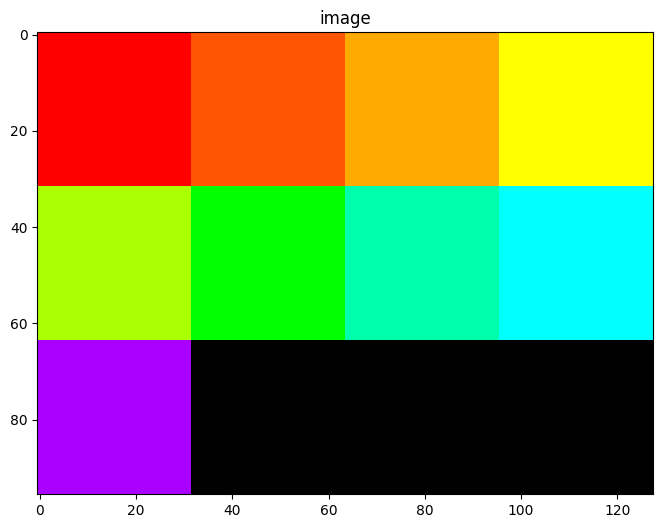

In [8]:
colors_hsv = np.uint8([[[0,255,255], [5,255,255], [10,255,255], [20,255,255], [30,255,255], [40,255,255], [50,255,255], [60,255,255], [70,255,255], \
                        [80,255,255], [90,255,255], [100,255,255], [110,255,255], [120,255,255], [130,255,255], [140,255,255]]])
colors_bgr = cv2.cvtColor(colors_hsv, cv2.COLOR_HSV2BGR).squeeze()[(0,2,3,4,5,7,9,10,15), :]
print(colors_bgr)
block_num = len(colors_bgr)
cols = 4
rows = int(np.ceil(block_num / cols))
image = np.zeros([32*rows, 32*cols, 3], dtype=np.uint8)

for i, bgr in enumerate(colors_bgr):
    r = i // cols
    c = i % cols
    image[r*32:(r+1)*32, c*32:(c+1)*32, :] = bgr

# Plot result
plt.close('all')
row = 1
col = 1

plt.subplot(row,col,1)
plt.title('image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.gcf().set_size_inches(18, 6*row)
plt.show()

In [9]:
def nms(box_events, scores, iou_thresh=0.5):
    """NMS on box_events

    Args:
        box_events (np.ndarray): nx1 with dtype EventBbox, the sorting order of those box is used as a
            a criterion for the nms.
        scores (np.ndarray): nx1 dtype of plain dtype, needs to be argsortable.
        iou_thresh (float): if two boxes overlap with more than `iou_thresh` (intersection over union threshold)
            with each other, only the one with the highest criterion value is kept.

    Returns:
        keep (np.ndarray): Indices of the box to keep in the input array.
    """
    x1 = box_events['x']
    y1 = box_events['y']
    x2 = box_events['x'] + box_events['w']
    y2 = box_events['y'] + box_events['h']

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= iou_thresh)[0]
        order = order[inds + 1]

    return sorted(keep)

In [4]:
event_dat_dir = "/home/tkyen/opencv_practice/data_1/Gen1_Automotive/detection_dataset_duration_60s_ratio_1.0/test"
gt_label_dir = "/home/tkyen/opencv_practice/data_1/Gen1_Automotive/HMNet/test_lbl"
dt_label_dir = "/home/tkyen/opencv_practice/HMNet/experiments/detection/workspace/hmnet_B3_yolox/result/pred_test_10"
video_dir = dt_label_dir + "_video"
os.makedirs(video_dir, exist_ok=True)

event_dat_list = sorted(glob.glob(os.path.join(event_dat_dir, "*.dat")))
gt_label_list = sorted(glob.glob(os.path.join(gt_label_dir, "*.npy")))
dt_label_list = sorted(glob.glob(os.path.join(dt_label_dir, "*.npy")))
downsample = 0
selected_files = []

In [5]:
event_dat_dir = "/home/tkyen/opencv_practice/data_3/Gen1_Automotive/detection_dataset_duration_60s_ratio_1.0/test_aug"
gt_label_dir = "/home/tkyen/opencv_practice/data_1/Gen1_Automotive/HMNet_aug/test_lbl"
dt_label_dir = "/home/tkyen/opencv_practice/HMNet/experiments/detection/workspace/hmnet_B3_yolox_tbptt/result/pred_test_hmnet_aug"
video_dir = dt_label_dir + "_video"
os.makedirs(video_dir, exist_ok=True)

event_dat_list = sorted(glob.glob(os.path.join(event_dat_dir, "*.dat")))
gt_label_list = sorted(glob.glob(os.path.join(gt_label_dir, "*.npy")))
dt_label_list = sorted(glob.glob(os.path.join(dt_label_dir, "*.npy")))
downsample = 0
selected_files = []

In [6]:
event_dat_dir = "/home/tkyen/opencv_practice/data_3/Gen1_Automotive/Gen4to1/test_gen4to1_dat"
gt_label_dir = "/home/tkyen/opencv_practice/data_1/Gen1_Automotive/HMNet_Gen4to1/test_lbl"
dt_label_dir = "/home/tkyen/opencv_practice/HMNet/experiments/detection/workspace/hmnet_B3_yolox_tbptt/result/pred_test_gen4to1"
video_dir = dt_label_dir + "_video"
os.makedirs(video_dir, exist_ok=True)

event_dat_list = sorted(glob.glob(os.path.join(event_dat_dir, "*.dat")))
gt_label_list = sorted(glob.glob(os.path.join(gt_label_dir, "*.npy")))
dt_label_list = sorted(glob.glob(os.path.join(dt_label_dir, "*.npy")))
downsample = 0
selected_files = []

In [4]:
event_dat_dir = "/home/tkyen/opencv_practice/data_1/Gen4_Automotive/test_dat"
gt_label_dir = "/home/tkyen/opencv_practice/data_3/Gen4_Automotive_event_cube_paper/result_vanilla_ssd_level_5_SORT/evaluation_epoch_48_Vanilla_Track/gt"
dt_label_dir = "/home/tkyen/opencv_practice/data_3/Gen4_Automotive_event_cube_paper/result_vanilla_ssd_level_5_SORT/evaluation_epoch_48_Vanilla_Track/dt"
video_dir = dt_label_dir + "_video"
os.makedirs(video_dir, exist_ok=True)

event_dat_list = [] #sorted(glob.glob(os.path.join(event_dat_dir, "*.dat")))
gt_label_list = sorted(glob.glob(os.path.join(gt_label_dir, "*.npy")))
dt_label_list = sorted(glob.glob(os.path.join(dt_label_dir, "*.npy")))
downsample = 1

for gt_label_path in gt_label_list:
    event_dat_name = os.path.basename(gt_label_path).replace('_bbox.npy', '_td.dat')
    event_dat_list.append(os.path.join(event_dat_dir, event_dat_name))
    print(event_dat_name)
selected_files = []
# selected_files = ["moorea_2019-02-19_005_td_915500000_975500000"]

# event_dat_path = os.path.join(event_dat_dir, "moorea_2019-02-19_005_td_915500000_975500000_td.dat")
# event_dat = EventDatReader(event_dat_path)
# event_dat.seek_time(0)
# ev_height, ev_width = event_dat.get_size()
# if downsample > 0:
#     ev_height = ev_height >> downsample
#     ev_width = ev_width >> downsample
# history = np.zeros((ev_height, ev_width), dtype=np.uint16)

# gt_label_path = os.path.join(gt_label_dir, "moorea_2019-02-19_001_td_1220500000_1280500000_bbox.npy")
# gt_label = EventNpyReader(gt_label_path)
# gt_label.seek_time(0)

# dt_label_path = os.path.join(dt_label_dir, "moorea_2019-02-19_001_td_1220500000_1280500000_bbox.npy")
# dt_label = EventNpyReader(dt_label_path)
# dt_label.seek_time(0)

# delta_t = 100000
# dt_boxes = dt_label.load_delta_t(delta_t=delta_t)
# print(dt_boxes)

# for i in range(39050//50+1):
#     events = event_dat.load_delta_t(delta_t=delta_t)
#     gt_boxes = gt_label.load_delta_t(delta_t=delta_t)
#     if downsample > 0:
#         events['x'] = events['x'] >> downsample
#         events['y'] = events['y'] >> downsample
#     x = events['x']
#     y = events['y']
#     t = events['t'] // 1000 # us->ms
#     history[y, x] = t

moorea_2019-02-19_005_td_1159500000_1219500000_td.dat
moorea_2019-02-19_005_td_1220500000_1280500000_td.dat
moorea_2019-02-19_005_td_915500000_975500000_td.dat
moorea_2019-02-21_000_td_2440500000_2500500000_td.dat


[(39050000,   0.     , 185.50732, 175.61494  , 125.6279   , 3, 3265, 0.998196)
 (39050000, 235.04968, 149.94768, 170.90057  , 138.48183  , 3, 3280, 0.997911)
 (39050000, 255.86389,   0.     ,  20.176788 ,   2.3970299, 7, 3286, 0.994216)
 (39050000, 406.623  ,  90.17247,  17.080109 ,  43.755814 , 7, 3324, 0.971232)
 (39050000, 243.74602, 123.47481,   6.6302185,  15.096558 , 7, 3319, 0.967987)
 (39050000, 418.89227, 169.08122,   7.2346497,  17.751068 , 7, 3333, 0.945341)
 (39050000, 271.60107, 122.27324,   6.745636 ,  14.516769 , 7, 3303, 0.925026)]
161 39096
(38935,) (38936,)


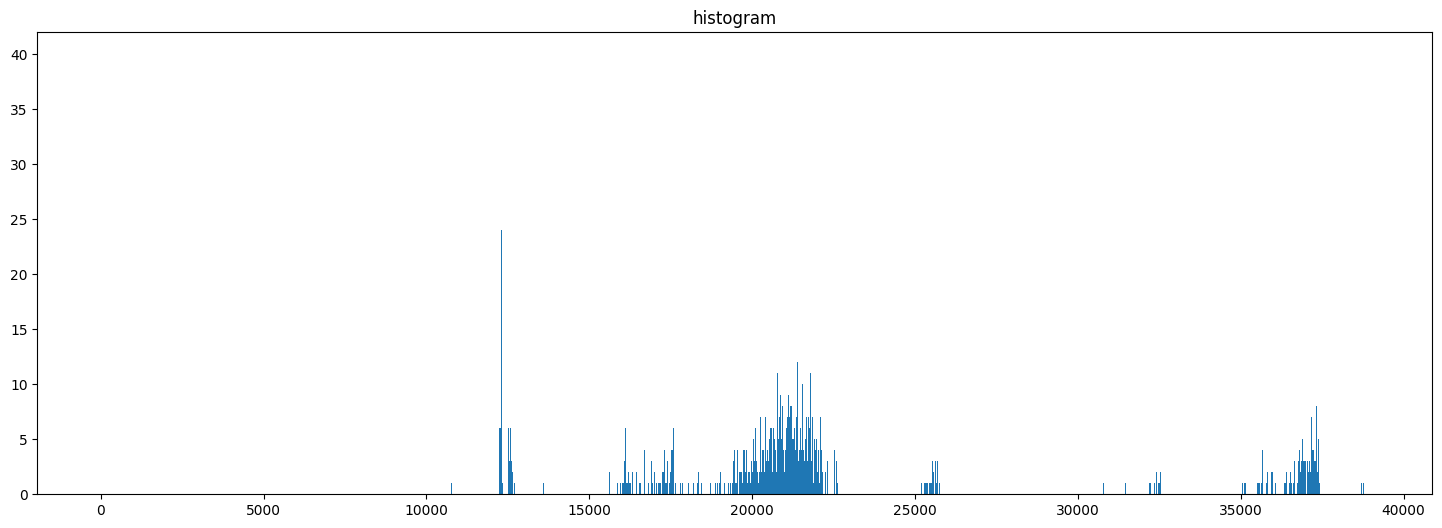

In [49]:
print(gt_boxes)
object = history[185:185+126, 0:0+176]
L = np.min(object[object>0])
H = np.max(object[object>0])
print(L, H)
H = H + 1
hist = np.histogram(object, bins=list(np.arange(L,H)))
y, x = hist
print(y.shape, x.shape)
# Plot result
plt.close('all')
row = 1
col = 1

plt.subplot(row,col,1)
plt.title('histogram')
plt.bar(np.arange(len(y)), y, width=1.0)

plt.gcf().set_size_inches(18, 6*row)
plt.show()


In [28]:
title = "RED"
event_dat_dir = "/home/tkyen/opencv_practice/data_1/Gen4_Automotive/test_dat"
gt_label_dir = "/home/tkyen/opencv_practice/data_3/Gen4_Automotive_event_cube_paper/result_vanilla_ssd_level_5/evaluation_epoch_31_Vanilla/gt"
dt_label_dir = "/home/tkyen/opencv_practice/data_3/Gen4_Automotive_event_cube_paper/result_vanilla_ssd_level_5/evaluation_epoch_31_Vanilla/dt"
video_dir = dt_label_dir + "_video"
os.makedirs(video_dir, exist_ok=True)

downsample = 1
selected_files = ["moorea_2019-02-19_005_td_915500000_975500000",
                  "moorea_2019-02-19_005_td_1159500000_1219500000",
                  "moorea_2019-02-19_005_td_1220500000_1280500000",
                  "moorea_2019-02-21_000_td_2440500000_2500500000"]
event_dat_list = [os.path.join(event_dat_dir, "{}_td.dat".format(selected_file)) for selected_file in selected_files]
gt_label_list = [os.path.join(gt_label_dir, "{}_bbox.npy".format(selected_file)) for selected_file in selected_files]
dt_label_list = [os.path.join(dt_label_dir, "{}_bbox.npy".format(selected_file)) for selected_file in selected_files]

In [17]:
title = "Permatrack"
event_dat_dir = "/home/tkyen/opencv_practice/data_1/Gen4_Automotive/test_dat"
gt_label_dir = "/home/tkyen/opencv_practice/permatrack/data/gen4/annotations/tracking_test"
dt_label_dir = "/home/tkyen/opencv_practice/permatrack/exp/tracking/gen4_supinvis_full_data_distributed_dataloader/model_54/dt"
video_dir = dt_label_dir + "_video"
os.makedirs(video_dir, exist_ok=True)

downsample = 1
selected_files = ["moorea_2019-02-19_005_td_915500000_975500000",
                  "moorea_2019-02-19_005_td_1159500000_1219500000",
                  "moorea_2019-02-19_005_td_1220500000_1280500000",
                  "moorea_2019-02-21_000_td_2440500000_2500500000",
                  'moorea_2019-06-14_000_854500000_914500000',
                  'moorea_2019-06-14_000_976500000_1036500000',
                  'moorea_2019-06-14_000_793500000_853500000'][4:5]
event_dat_list = [os.path.join(event_dat_dir, "{}_td.dat".format(selected_file)) for selected_file in selected_files]
gt_label_list = [os.path.join(gt_label_dir, "{}_bbox.npy".format(selected_file)) for selected_file in selected_files]
dt_label_list = [os.path.join(dt_label_dir, "{}_bbox.npy".format(selected_file)) for selected_file in selected_files]

In [16]:
def check_dtype(boxes_dtype):
    if boxes_dtype == [('t', '<u8'), ('x', '<f4'), ('y', '<f4'), ('w', '<f4'), ('h', '<f4'), ('class_id', 'u1'), 
                          ('class_confidence', '<f4'), ('track_id', '<u4')]:
        return 0
    elif boxes_dtype == [('t', '<u8'), ('x', '<f4'), ('y', '<f4'), ('w', '<f4'), ('h', '<f4'), ('class_id', 'u1'), 
                          ('class_confidence', '<f4'), ('track_id', '<u4'), ('visibility', 'f4')]:
        return 1
    elif boxes_dtype == [('t', '<u8'), ('x', '<f4'), ('y', '<f4'), ('w', '<f4'), ('h', '<f4'), ('class_id', 'u1'), 
                          ('class_confidence', '<f4'), ('track_id', '<u4'), ('visibility', 'u1')]:
        return 2
    elif boxes_dtype == {'names':['t','x','y','w','h','class_id','track_id','class_confidence'], 
                            'formats':['<i8','<f4','<f4','<f4','<f4','<u4','<u4','<f4'], 
                            'offsets':[0,8,12,16,20,24,28,32], 'itemsize':40}:
        return 3
    assert False

def check_flags(boxes_dtype_names):
    if 'visibility' in boxes_dtype_names:
        visibility_flag = True
    else:
        visibility_flag = False

    if 'vx' in boxes_dtype_names and 'vy' in boxes_dtype_names:
        vector_flag = True
    else:
        vector_flag = False

    if 'tx' in boxes_dtype_names and 'ty' in boxes_dtype_names:
        tracking_flag = True
    else:
        tracking_flag = False
    
    return visibility_flag, vector_flag, tracking_flag

for idx, (event_dat_path, gt_label_path, dt_label_path) in enumerate(zip(event_dat_list, gt_label_list, dt_label_list)):
    event_file = os.path.basename(event_dat_path).replace('_td.dat', '')
    gt_file = os.path.basename(gt_label_path).replace('_bbox.npy', '')
    dt_file = os.path.basename(dt_label_path).replace('_bbox.npy', '')
    assert event_file==gt_file==dt_file

    if len(selected_files) > 0:
        if event_file not in selected_files:
            continue

    event_dat = EventDatReader(event_dat_path)
    event_dat.seek_time(0)
    ev_height, ev_width = event_dat.get_size()
    if downsample > 0:
        ev_height = ev_height >> downsample
        ev_width = ev_width >> downsample

    gt_label = EventNpyReader(gt_label_path)
    gt_label.seek_time(0)

    dt_label = EventNpyReader(dt_label_path)
    dt_label.seek_time(0)

    delta_t = 50000
    print(event_file)
    # VideoWriter
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
    frame_rate = 10
    video_writer = cv2.VideoWriter(os.path.join(video_dir, '{}.mp4'.format(event_file)), fourcc, frame_rate, (ev_width*2, ev_height))
    colors = colors_bgr.tolist()

    track_ids = {}
    for frame_i in range(int(60e6//delta_t)):
        events = event_dat.load_delta_t(delta_t=delta_t)
        gt_boxes = gt_label.load_delta_t(delta_t=delta_t)
        dt_boxes = dt_label.load_delta_t(delta_t=delta_t)
        dt_boxes = dt_boxes[nms(dt_boxes, dt_boxes['class_confidence'], iou_thresh=0.5)]

        if idx == 0 and frame_i == 0:
            print(gt_boxes.dtype)
            print(dt_boxes.dtype)

        # gt_boxes_dtype = check_dtype(gt_boxes.dtype)
        # dt_boxes_dtype = check_dtype(dt_boxes.dtype)

        # dt_boxes = dt_boxes[nms(dt_boxes, dt_boxes['class_confidence'], iou_thresh=0.5)]

        if downsample > 0:
            events['x'] = events['x'] >> downsample
            events['y'] = events['y'] >> downsample

        if len(gt_boxes) > 0:
            assert gt_boxes['t'][0]>=delta_t*frame_i and gt_boxes['t'][-1]<delta_t*(frame_i+1)
        if len(dt_boxes) > 0:
            assert dt_boxes['t'][0]>=delta_t*frame_i and dt_boxes['t'][-1]<delta_t*(frame_i+1)

        image_all = np.zeros((ev_height, ev_width*2, 3), dtype=np.uint8)
        BaseFrameGenerationAlgorithm.generate_frame(events, image_all[:,:ev_width, :])
        image_all[:,ev_width:, :] = image_all[:,:ev_width, :].copy()

        cv2.putText(image_all, 'GT',
                    (10, 20), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (0, 255, 255), 1, cv2.LINE_AA)
        cv2.putText(image_all, '{} ms / {} ms'.format(frame_i*delta_t//1000, (frame_i+1)*delta_t//1000), 
                    (ev_width-200, 20), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (0, 255, 255), 1, cv2.LINE_AA)
        cv2.putText(image_all, 'DT',
                    (ev_width+10, 20), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (0, 255, 255), 1, cv2.LINE_AA)
        cv2.putText(image_all, title,
                    (2*ev_width-150, 20), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (0, 255, 255), 1, cv2.LINE_AA)
        image_all = cv2.line(image_all, (ev_width,0), (ev_width,ev_height), (0,255,255), 1)

        visibility_flag, vector_flag, tracking_flag = check_flags(gt_boxes.dtype.names)
        for gt_box in gt_boxes:        
            # if gt_boxes_dtype == 0:
            #     t, x, y, w, h, class_id, confidence, track_id = gt_box
            # elif gt_boxes_dtype == 1 or gt_boxes_dtype == 2:
            #     t, x, y, w, h, class_id, confidence, track_id, visibility = gt_box
            # elif gt_boxes_dtype == 3:
            #     t, x, y, w, h, class_id, track_id, confidence = gt_box
            for key in gt_box.dtype.names:
                val = gt_box[key]
                exec(key + '=val')

            if visibility <= 0.1:
                print(visibility, vx, vy)
            if visibility_flag and visibility<0.4:
                color = colors[0]
            else:
                color = colors[class_id]

            x, y, w, h = int(x), int(y), int(w), int(h)
            cv2.rectangle(image_all, (x, y), (x+w, y+h), color, 1)
            cv2.putText(image_all, str(int(track_id)),
                        (x, y+h), cv2.FONT_HERSHEY_TRIPLEX, 0.5, color, 1, cv2.LINE_AA)
            # cv2.putText(image_all, str(round(visibility, 2)), (x, y+h), cv2.FONT_HERSHEY_TRIPLEX, 0.6, color, 1, cv2.LINE_AA)

        visibility_flag, vector_flag, tracking_flag = check_flags(dt_boxes.dtype.names)
        for dt_box in dt_boxes:
            # if dt_boxes_dtype == 0:
            #     t, x, y, w, h, class_id, confidence, track_id = dt_box
            # elif dt_boxes_dtype == 1 or dt_boxes_dtype == 2:
            #     t, x, y, w, h, class_id, confidence, track_id, visibility = dt_box
            # elif dt_boxes_dtype == 3:
            #     t, x, y, w, h, class_id, track_id, confidence = dt_box
            for key in dt_box.dtype.names:
                val = dt_box[key]
                exec(key + '=val')

            if visibility_flag and visibility<0.4:
                color = colors[0]
            else:
                color = colors[class_id]

            if class_confidence >= 0.4:
                # if visibility >= 0.5:
                #    track_ids[track_id] = True
                # else:
                #     if track_id not in track_ids.keys():
                #         track_ids[track_id] = False
                #         continue
                #     elif track_ids[track_id] == False:
                #         continue
                #     else:
                #         track_ids[track_id] = True

                x, y, w, h = int(x), int(y), int(w), int(h)
                cv2.rectangle(image_all, (ev_width+x, y), (ev_width+x+w, y+h), color, 1)
                cv2.putText(image_all, str(round(class_confidence, 3)), (ev_width+x, y-15), cv2.FONT_HERSHEY_TRIPLEX, 0.6, color, 1, cv2.LINE_AA)
                cv2.putText(image_all, str(round(visibility, 3)), (ev_width+x, y+h), cv2.FONT_HERSHEY_TRIPLEX, 0.6, color, 1, cv2.LINE_AA)

        video_writer.write(image_all)
    video_writer.release()

moorea_2019-06-14_000_854500000_914500000
[('t', '<u8'), ('x', '<f4'), ('y', '<f4'), ('w', '<f4'), ('h', '<f4'), ('class_id', 'u1'), ('class_confidence', '<f4'), ('track_id', '<u4'), ('visibility', '<f4'), ('vx', '<f4'), ('vy', '<f4')]
[('t', '<u8'), ('x', '<f4'), ('y', '<f4'), ('w', '<f4'), ('h', '<f4'), ('class_id', 'u1'), ('class_confidence', '<f4'), ('track_id', '<u4'), ('visibility', '<f4'), ('vx', '<f4'), ('vy', '<f4'), ('tx', '<f4'), ('ty', '<f4')]
0.0 -0.27799988 0.06348419
0.0 -0.11532593 0.39676666
0.0 -0.19412231 -0.32723236
0.0 -0.027114868 0.92788696
0.0 -0.084503174 -0.36721802
0.0 -0.1938324 0.04647827
0.0 -1.3657074 -0.1208725
0.0 -0.06865692 0.0046463013
0.0 -0.13043213 0.17758179
0.0 -0.018875122 0.08024597
0.0 0.20176697 0.2430191
0.0 0.15631104 -0.0705719
0.0 1.6499329 0.14025879
0.0 -0.22068787 -0.062042236
0.0 -0.061706543 0.29721832
0.0 0.17912292 0.07120514
0.0 0.006591797 0.07935333
0.0 -0.38923645 0.38089752
0.0 -0.1015625 0.017471313
0.0 0.34535217 -0.1009597

In [24]:
def filter_bboxes(bboxes):
  # bboxes.dtype = {'names':['t','x','y','w','h','class_id','track_id','class_confidence'], 
  #                 'formats':['<i8','<f4','<f4','<f4','<f4','<u4','<u4','<f4'], 
  #                 'offsets':[0,8,12,16,20,24,28,32], 'itemsize':40}
  filtered_bboxes = np.empty(0, dtype=bboxes.dtype)

  track_ids = sorted(set(bboxes['track_id']))
  for track_id in track_ids:
    t = 0
    x1 = np.inf
    y1 = np.inf
    x2 = 0
    y2 = 0
    class_confidence = 0
    votes_table = {}
    for bbox in bboxes[bboxes['track_id']==track_id]:
      _t, _x, _y, _w, _h, _class_id, _track_id, _class_confidence = bbox
      t = np.maximum(t, _t)
      x1 = np.minimum(x1, _x)
      y1 = np.minimum(y1, _y)
      x2 = np.maximum(x2, _x + _w)
      y2 = np.maximum(y2, _y + _h)
      class_confidence = np.maximum(class_confidence, _class_confidence)
      if _class_id in votes_table:    # Check if key in hash table
          votes_table[_class_id] += 1 # Increment counter
      else:
          votes_table[_class_id] = 1  # Create counter for vote
    class_id = max(votes_table, key=votes_table.get)
    _boxes = np.array([(t, x1, y1, x2-x1, y2-y1, class_id, track_id, class_confidence)], dtype=bboxes.dtype)
    filtered_bboxes = np.concatenate((filtered_bboxes, _boxes), axis=0)
  return filtered_bboxes

def get_overlapped_bboxes(gt_boxes, i):
    ti, xi, yi, wi, hi, class_id_i, track_id_i, confidence_i = gt_boxes[i]
    overlapped_bboxes = []
    # print([xi, yi, xi+wi, yi+hi])
    # print(gt_boxes)
    for j, gt_box in enumerate(gt_boxes):
        tj, xj, yj, wj, hj, class_id_j, track_id_j, confidence_j = gt_boxes[j]
        if track_id_j == track_id_i:
            continue
        x1 = np.max([xi, xj])
        y1 = np.max([yi, yj])
        x2 = np.min([xi+wi, xj+wj])
        y2 = np.min([yi+hi, yj+hj])
        if x1 < x2 and y1 < y2:
            overlapped_bboxes.append([int(x1)-int(xi), int(y1)-int(yi), int(x2)-int(xi), int(y2)-int(yi)])
    # print(overlapped_bboxes)
    return overlapped_bboxes

for idx, (event_dat_path, gt_label_path, dt_label_path) in enumerate(zip(event_dat_list, gt_label_list, dt_label_list)):
    if idx!=0:
        continue
    event_file = os.path.basename(event_dat_path).replace('_td.dat', '')
    gt_file = os.path.basename(gt_label_path).replace('_bbox.npy', '')
    dt_file = os.path.basename(dt_label_path).replace('_bbox.npy', '')
    assert event_file==gt_file==dt_file
        
    if len(selected_files) > 0:
        if event_file not in selected_files:
            continue

    event_dat = EventDatReader(event_dat_path)
    event_dat.seek_time(0)
    ev_height, ev_width = event_dat.get_size()
    if downsample > 0:
        ev_height = ev_height >> downsample
        ev_width = ev_width >> downsample

    gt_label = EventNpyReader(gt_label_path)
    gt_label.seek_time(0)

    dt_label = EventNpyReader(dt_label_path)
    dt_label.seek_time(0)

    delta_t = 50000
    print(event_file)
    # VideoWriter
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
    frame_rate = 10
    video_writer = cv2.VideoWriter(os.path.join(video_dir, '{}.mp4'.format(event_file)), fourcc, frame_rate, (ev_width*2, ev_height))
    colors = colors_bgr.tolist()

    pre_gt_boxes = None
    still_hits = {}
    for frame_i in range(int(60e6//delta_t)):
        events = event_dat.load_delta_t(delta_t=delta_t)
        gt_boxes = gt_label.load_delta_t(delta_t=delta_t)
        # gt_boxes = gt_boxes[nms(gt_boxes, gt_boxes['class_confidence'], iou_thresh=0.5)]
        gt_boxes = filter_bboxes(gt_boxes)
        dt_boxes = dt_label.load_delta_t(delta_t=delta_t)
        dt_boxes = dt_boxes[nms(dt_boxes, dt_boxes['class_confidence'], iou_thresh=0.5)]

        if frame_i == 0:
            print(gt_boxes.dtype)
            print(dt_boxes.dtype)

        occupancy_map = np.zeros((ev_height, ev_width, 3), dtype=np.uint8)
        if downsample > 0:
            events['x'] = events['x'] >> downsample
            events['y'] = events['y'] >> downsample
        occupancy_map[events['y'], events['x'], :] = 255
        occupancy_mask = np.all(occupancy_map==255, axis=2)

        if len(gt_boxes) > 0:
            assert gt_boxes['t'][0]>=delta_t*frame_i and gt_boxes['t'][-1]<delta_t*(frame_i+1)
        if len(dt_boxes) > 0:
            assert dt_boxes['t'][0]>=delta_t*frame_i and dt_boxes['t'][-1]<delta_t*(frame_i+1)

        image_all = np.zeros((ev_height, ev_width*2, 3), dtype=np.uint8)
        BaseFrameGenerationAlgorithm.generate_frame(events, image_all[:,:ev_width, :])
        # image_all[:,ev_width:, :] = image_all[:,:ev_width, :].copy()
        image_all[:,ev_width:, :] = occupancy_map.copy()
        cv2.putText(image_all, '{} ms / {} ms'.format(frame_i*delta_t//1000, (frame_i+1)*delta_t//1000), 
                    (ev_width-200, 20), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (0, 255, 255), 1, cv2.LINE_AA)
        cv2.putText(image_all, 'GT',
                    (10, 20), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (0, 255, 255), 1, cv2.LINE_AA)
        cv2.putText(image_all, 'DT',
                    (ev_width+10, 20), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (0, 255, 255), 1, cv2.LINE_AA)
        image_all = cv2.line(image_all, (ev_width,0), (ev_width,ev_height), (0,255,255), 1)

        gt_box_used = np.array([0]*len(gt_boxes))
        gt_track_ids = []
        for i, gt_box in enumerate(gt_boxes):
            if len(gt_box) == 9:
                t, x, y, w, h, class_id, confidence, track_id, invalid = gt_box
                x, y, w, h = int(x), int(y), int(w), int(h)
                if invalid == False:
                    cv2.rectangle(image_all, (x, y), (x+w, y+h), colors[class_id], 1)
            else:
                if gt_box_used[i] == -1:
                    continue
                t, x, y, w, h, class_id, track_id, confidence = gt_box
                # if track_id==4382:
                #     print(gt_box)
                gt_box_used[i] = 1
                gt_track_ids.append(track_id)
                if np.sum(gt_boxes['track_id']==track_id) > 1:
                    for j in np.where(gt_boxes['track_id']==track_id)[0]:
                        if j != i:
                            gt_box_used[j] = -1
                    gt_boxes_id = gt_boxes[gt_boxes['track_id']==track_id]
                    gt_boxes[i]['t'] = int(np.mean(gt_boxes_id['t']))
                    gt_boxes[i]['x'] = np.mean(gt_boxes_id['x'])
                    gt_boxes[i]['y'] = np.mean(gt_boxes_id['y'])
                    gt_boxes[i]['w'] = np.mean(gt_boxes_id['w'])
                    gt_boxes[i]['h'] = np.mean(gt_boxes_id['h'])
                    gt_boxes[i]['class_confidence'] = np.mean(gt_boxes_id['class_confidence'])
                    t, x, y, w, h, class_id, track_id, confidence = gt_boxes[i]

                cx = x + w / 2
                cy = y + h / 2
                x, y, w, h = int(x), int(y), int(w), int(h)

                mask = np.ones((h, w), dtype=bool)
                overlapped_bboxes = get_overlapped_bboxes(gt_boxes, i)
                for overlapped_bbox in overlapped_bboxes:
                    x1, y1, x2, y2 = overlapped_bbox
                    mask[y1:y2, x1:x2] = False
                
                occ_true = np.sum((occupancy_mask[y:y+h, x:x+w]==True)*mask)
                occ_false = np.sum((occupancy_mask[y:y+h, x:x+w]==False)*mask)
                if occ_true + occ_false > 0: 
                    occ_rate = occ_true / (occ_true + occ_false)
                else:
                    occ_rate = 0
                cv2.rectangle(image_all, (x, y), (x+w, y+h), colors[class_id], 1)
                # cv2.putText(image_all, str(int(track_id)),
                #             (x, y-10), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)

                if isinstance(pre_gt_boxes, np.ndarray):
                    if np.any(pre_gt_boxes['track_id']==track_id):
                        pre_gt_box = pre_gt_boxes[pre_gt_boxes['track_id']==track_id]
                        pre_t, pre_x, pre_y, pre_w, pre_h, pre_class_id, pre_track_id, pre_confidence = pre_gt_box[0]
                        pre_cx = pre_x + pre_w / 2
                        pre_cy = pre_y + pre_h / 2
                        velocity = np.array([(pre_cx-cx)/w, (pre_cy-cy)/h])
                        vel = math.sqrt(np.sum(velocity**2))

                        if track_id not in still_hits.keys():
                            still_hits[track_id] = 0

                        if vel < 0.03 and occ_rate < 0.05:
                            # if track_id==4382 and track_id in still_hits.keys():
                            #     print(frame_i, t//1000, "still_hits 1")
                            if still_hits[track_id] < 5:
                                still_hits[track_id] = still_hits[track_id] + 1
                            cv2.rectangle(image_all, (x, y), (x+w, y+h), (0, 0, 255), 1)
                        elif vel < 0.03 and occ_rate < 0.1:
                            # if track_id==4382 and track_id in still_hits.keys():
                            #     print(frame_i, t//1000, "still_hits 2")
                            if still_hits[track_id] < 5:
                                still_hits[track_id] = still_hits[track_id] + 1
                            cv2.rectangle(image_all, (x, y), (x+w, y+h), (0, 0, 255), 1)
                        else:
                            # if track_id==4382 and track_id in still_hits.keys():
                            #     print(frame_i, t//1000, "Not still_hits")
                            if still_hits[track_id] > 0:
                                still_hits[track_id] = still_hits[track_id] - 1
                                cv2.rectangle(image_all, (x, y), (x+w, y+h), (0, 0, 255), 1)

                        # if track_id==4382 and track_id in still_hits.keys():
                        #     print(frame_i, t//1000, still_hits[4382])
                        #     print()
                        cv2.putText(image_all, "({} :{:.2f} / {:.2f})".format(track_id, vel, occ_rate),
                            (x, y-10), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                        # cv2.putText(image_all, "{:.2f} / {:.2f}".format(vel, occ_rate),
                        #     (x, y-10), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                elif occ_rate < 0.1:
                    if track_id not in still_hits.keys():
                        still_hits[track_id] = 0
                    if still_hits[track_id] < 5:
                        still_hits[track_id] = still_hits[track_id] + 1
        if isinstance(pre_gt_boxes, np.ndarray):
            for pre_gt_box in pre_gt_boxes:
                pre_track_id = pre_gt_box[6]
                # print(pre_track_id, gt_track_ids, still_hits.keys())
                if pre_track_id not in gt_track_ids and pre_track_id in still_hits.keys():
                    del still_hits[pre_track_id]
                
        pre_gt_boxes = gt_boxes[gt_box_used==1]
        assert len(set(pre_gt_boxes['track_id'])) == len(pre_gt_boxes['track_id'])
        for dt_box in dt_boxes:
            t, x, y, w, h, class_id, track_id, confidence = dt_box
            # t, x, y, w, h, class_id, confidence, track_id = dt_box
            # print(t, x, y, w, h, class_id, confidence, track_id)
            if confidence > 0.5:
                x, y, w, h = int(x), int(y), int(w), int(h)
                cv2.putText(image_all, str(round(confidence, 3)), (ev_width+x, y-6), cv2.FONT_HERSHEY_TRIPLEX, 0.6, colors[class_id], 1, cv2.LINE_AA)
                cv2.rectangle(image_all, (ev_width+x, y), (ev_width+x+w, y+h), colors[class_id], 1)

        video_writer.write(image_all)
    video_writer.release()

moorea_2019-02-19_005_td_915500000_975500000
[('t', '<u8'), ('x', '<f4'), ('y', '<f4'), ('w', '<f4'), ('h', '<f4'), ('class_id', 'u1'), ('class_confidence', '<f4'), ('track_id', '<u4')]
[('t', '<i8'), ('x', '<f4'), ('y', '<f4'), ('w', '<f4'), ('h', '<f4'), ('class_id', '<u4'), ('track_id', '<u4'), ('class_confidence', '<f4')]


ValueError: operands could not be broadcast together with shapes (15,0) (140,196) 